### Classification Task

In [37]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

import torch
import torchvision
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn

In [38]:
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True)

SAMPLE AT INDEX 0
LABEL: boot
Label index: 9
Numpy array shape: (28, 28)
Numpy array type: uint8
PyTorch tensor shape: torch.Size([1, 28, 28])
PyTorch tensor type: torch.float32


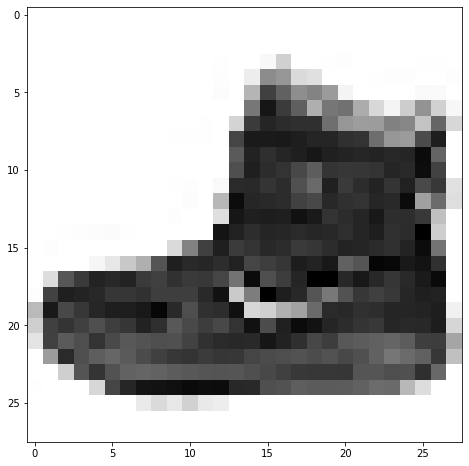

In [39]:
# getting an image and the corresponding label
label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']
sample_index = 0
num_labels = len(label_names)
image = train_dataset[sample_index][0]
label = label_names[train_dataset[sample_index][1]]

fig = plt.figure(figsize=(8,8))
plt.imshow(image, cmap='Greys')
print(f"SAMPLE AT INDEX {sample_index}")
print(f"LABEL: {label}")
print(f"Label index: {train_dataset[sample_index][1]}")

# convert the image to a numpy array
image_numpy = np.array(image)

print(f'Numpy array shape: {image_numpy.shape}')
print(f'Numpy array type: {image_numpy.dtype}')

# convert the image to a torch tensor
to_tensor = torchvision.transforms.ToTensor()
image_tensor = to_tensor(image)

print(f'PyTorch tensor shape: {image_tensor.shape}')
print(f'PyTorch tensor type: {image_tensor.dtype}')

## Data transformation

In [40]:
train_transform = transforms.Compose([
    # OneHotEncoder(num_classes=10),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    # OneHotEncoder(num_classes=10),
    transforms.ToTensor()
])

# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

## Train / Validation split

In [41]:
#divide the train_dataset in train and validation sets (10% of the dataset)
train_ds, validation_ds = torch.utils.data.random_split(train_dataset, [50000, 10000])
test_ds = test_dataset #change name, just aesthetic

## Dataloader

In [42]:
# Define train dataloader
train_dataloader = DataLoader(train_ds, batch_size=256, shuffle=False) # shuffle=True

# Define validation dataloader
validation_dataloader = DataLoader(validation_ds, batch_size=256, shuffle=False) # shuffle=True

# Define test dataloader
test_dataloader = DataLoader(test_ds, batch_size=256, shuffle=False)


batch_data, batch_labels = next(iter(train_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f'Train dataloader size: {len(train_dataloader)}')
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(validation_dataloader))
print(f"VALIDATION BATCH SHAPE")
print(f'Validation dataloader size: {len(validation_dataloader)}')
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataloader))
print(f"TEST BATCH SHAPE")
print(f'Test dataloader size: {len(test_dataloader)}')
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
Train dataloader size: 196
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
VALIDATION BATCH SHAPE
Validation dataloader size: 40
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TEST BATCH SHAPE
Test dataloader size: 40
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


## Convolutional Network

In [43]:
#good convolutinal neural network architecture, 88% accuracy with 150 epochs, v1
class myCNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        ### Convolutional section
        self.conv = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels= 1, out_channels=6, kernel_size=5),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Second convolutional layer
            nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=12*4*4, out_features=64),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            # Second linear
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(True),
            nn.Dropout(p=0.5),

            nn.Linear(in_features=32, out_features=10),
            nn.ReLU(True),

            # we don't need softmax since we'll use cross entropy loss
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.conv(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.lin(x)
        return x

In [44]:
#set seed
torch.manual_seed(42)

# Instantiate the model
cnn = myCNN()

## Training

In [45]:
# define the loss function
loss_fn = nn.CrossEntropyLoss()

#define optimizer
optimizer = torch.optim.Adam(cnn.parameters(), lr=1e-3)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

#move the model to the selected device
cnn.to(device)

Selected device: cuda


myCNN(
  (conv): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lin): Sequential(
    (0): Linear(in_features=192, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=32, out_features=10, bias=True)
    (7): ReLU(inplace=True)
  )
)

In [46]:
# Training function
def train_epoch(model, dataloader, loss_fn, optimizer, device):
    # Set the model to training mode
    model.train()
    # Initialize the loss
    running_loss = 0
    train_loss = []
    # Loop over the training batches
    for (data, label) in tqdm(dataloader):
        # target = onehot encoding of label
        target = torch.eye(10)[label] 
        # Move the input and target data to the selected device
        data, target = data.to(device), target.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Compute the output
        output = model(data)
        assert output.shape == target.shape
        # Compute the loss
        loss = loss_fn(output, target)
        # Compute the gradients
        loss.backward()
        # Update the weights
        optimizer.step()
        #batch loss
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)
    # Return the average training loss
    train_loss = np.mean(train_loss)
    print(f"Training loss: {train_loss}")
    return train_loss

#validation function
def validate_epoch(model, dataloader, loss_fn, device):
    # Set the model to evaluation mode
    model.eval()
    # Initialize the validation loss
    val_loss = []
    # Loop over the validation batches
    with torch.no_grad():
        for (data, label) in tqdm(dataloader):
            # target = onehot encoding of label
            target = torch.eye(10)[label] 
            # Move the input and target data to the selected device
            data, target = data.to(device), target.to(device)
            # Compute the output
            output = model(data)
            assert output.shape == target.shape
            # Compute the loss
            loss = loss_fn(output, target)
            #batch loss
            loss_batch = loss.detach().cpu().numpy()
            val_loss.append(loss_batch)
    # Return the average validation loss
    val_loss = np.mean(val_loss)
    print(f"Validation loss: {val_loss}")
    return val_loss

# Training loop

In [47]:
# decide to train or not
load_good_model = False # if True do not train a new model, if False train a new model
good_model_path = "good_models/cnn_v1_epoch_10.pth"

In [48]:
#create a folder called training to save the model
import pickle
if not load_good_model:
    if not os.path.exists('training'):
        os.makedirs('training')
    #clear the training folder
    if os.listdir('training'):
        for f in os.listdir('training'):
            os.remove(os.path.join('training', f))

In [49]:
# training loop
if not load_good_model:
    num_epochs = 200 #150
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        # Train the model
        train_loss = train_epoch(cnn, train_dataloader, loss_fn, optimizer, device)
        # Validate the model
        val_loss = validate_epoch(cnn, validation_dataloader, loss_fn, device)
        # Append the losses
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Save network parameters
        torch.save(cnn.state_dict(), f"training/cnn_epoch_{epoch+1}.pth")
    
    # Save the losses
    with open('training/losses.pkl', 'wb') as f:
        pickle.dump([train_losses, val_losses], f)
else:
    #load the model
    cnn.load_state_dict(torch.load(good_model_path))
    #load the losses
    with open('good_models/losses.pkl', 'rb') as f:
        [train_losses, val_losses] = pickle.load(f)
    #validate the model
    val_loss = validate_epoch(cnn, validation_dataloader, loss_fn, device)
    #test the model
    test_loss = validate_epoch(cnn, test_dataloader, loss_fn, device)


Epoch 1/200


100%|██████████| 196/196 [00:08<00:00, 22.88it/s]


Training loss: 1.6005951166152954


100%|██████████| 40/40 [00:01<00:00, 32.81it/s]


Validation loss: 0.8005119562149048

Epoch 2/200


100%|██████████| 196/196 [00:08<00:00, 24.40it/s]


Training loss: 0.9591575264930725


100%|██████████| 40/40 [00:01<00:00, 30.56it/s]


Validation loss: 0.6774619221687317

Epoch 3/200


100%|██████████| 196/196 [00:08<00:00, 23.66it/s]


Training loss: 0.8487194776535034


100%|██████████| 40/40 [00:01<00:00, 36.23it/s]


Validation loss: 0.6364499926567078

Epoch 4/200


100%|██████████| 196/196 [00:06<00:00, 28.51it/s]


Training loss: 0.7894232869148254


100%|██████████| 40/40 [00:01<00:00, 36.41it/s]


Validation loss: 0.5933418273925781

Epoch 5/200


100%|██████████| 196/196 [00:07<00:00, 24.99it/s]


Training loss: 0.7482326030731201


100%|██████████| 40/40 [00:01<00:00, 35.49it/s]


Validation loss: 0.5703220963478088

Epoch 6/200


100%|██████████| 196/196 [00:07<00:00, 25.45it/s]


Training loss: 0.7226252555847168


100%|██████████| 40/40 [00:01<00:00, 34.78it/s]


Validation loss: 0.5492681264877319

Epoch 7/200


100%|██████████| 196/196 [00:07<00:00, 26.73it/s]


Training loss: 0.6992691159248352


100%|██████████| 40/40 [00:01<00:00, 29.87it/s]


Validation loss: 0.5393171310424805

Epoch 8/200


100%|██████████| 196/196 [00:08<00:00, 24.34it/s]


Training loss: 0.6806847453117371


100%|██████████| 40/40 [00:01<00:00, 31.89it/s]


Validation loss: 0.5100170373916626

Epoch 9/200


100%|██████████| 196/196 [00:07<00:00, 25.61it/s]


Training loss: 0.6588837504386902


100%|██████████| 40/40 [00:01<00:00, 36.26it/s]


Validation loss: 0.5021805763244629

Epoch 10/200


100%|██████████| 196/196 [00:06<00:00, 28.58it/s]


Training loss: 0.6468913555145264


100%|██████████| 40/40 [00:01<00:00, 34.66it/s]


Validation loss: 0.499319851398468

Epoch 11/200


100%|██████████| 196/196 [00:07<00:00, 26.54it/s]


Training loss: 0.6354838609695435


100%|██████████| 40/40 [00:01<00:00, 36.79it/s]


Validation loss: 0.49984899163246155

Epoch 12/200


100%|██████████| 196/196 [00:07<00:00, 25.80it/s]


Training loss: 0.6179990172386169


100%|██████████| 40/40 [00:01<00:00, 34.46it/s]


Validation loss: 0.4819651246070862

Epoch 13/200


100%|██████████| 196/196 [00:07<00:00, 27.11it/s]


Training loss: 0.6099835634231567


100%|██████████| 40/40 [00:01<00:00, 29.74it/s]


Validation loss: 0.4759911000728607

Epoch 14/200


100%|██████████| 196/196 [00:07<00:00, 26.80it/s]


Training loss: 0.6050763130187988


100%|██████████| 40/40 [00:01<00:00, 31.41it/s]


Validation loss: 0.47330817580223083

Epoch 15/200


100%|██████████| 196/196 [00:07<00:00, 25.17it/s]


Training loss: 0.5952255725860596


100%|██████████| 40/40 [00:01<00:00, 30.78it/s]


Validation loss: 0.46786078810691833

Epoch 16/200


100%|██████████| 196/196 [00:09<00:00, 20.67it/s]


Training loss: 0.5849342942237854


100%|██████████| 40/40 [00:01<00:00, 27.21it/s]


Validation loss: 0.46011024713516235

Epoch 17/200


100%|██████████| 196/196 [00:07<00:00, 26.06it/s]


Training loss: 0.584595263004303


100%|██████████| 40/40 [00:01<00:00, 30.11it/s]


Validation loss: 0.45408859848976135

Epoch 18/200


100%|██████████| 196/196 [00:08<00:00, 23.94it/s]


Training loss: 0.581953227519989


100%|██████████| 40/40 [00:01<00:00, 33.18it/s]


Validation loss: 0.449624627828598

Epoch 19/200


100%|██████████| 196/196 [00:07<00:00, 26.54it/s]


Training loss: 0.5697571635246277


100%|██████████| 40/40 [00:01<00:00, 30.98it/s]


Validation loss: 0.44294801354408264

Epoch 20/200


100%|██████████| 196/196 [00:07<00:00, 26.57it/s]


Training loss: 0.5652801990509033


100%|██████████| 40/40 [00:01<00:00, 33.91it/s]


Validation loss: 0.4463699758052826

Epoch 21/200


100%|██████████| 196/196 [00:07<00:00, 26.57it/s]


Training loss: 0.5537882447242737


100%|██████████| 40/40 [00:01<00:00, 30.72it/s]


Validation loss: 0.4373149871826172

Epoch 22/200


100%|██████████| 196/196 [00:07<00:00, 28.00it/s]


Training loss: 0.5560151934623718


100%|██████████| 40/40 [00:01<00:00, 35.91it/s]


Validation loss: 0.45378875732421875

Epoch 23/200


100%|██████████| 196/196 [00:06<00:00, 29.07it/s]


Training loss: 0.5549119114875793


100%|██████████| 40/40 [00:01<00:00, 37.02it/s]


Validation loss: 0.42941349744796753

Epoch 24/200


100%|██████████| 196/196 [00:06<00:00, 28.85it/s]


Training loss: 0.5478878617286682


100%|██████████| 40/40 [00:01<00:00, 36.74it/s]


Validation loss: 0.43131715059280396

Epoch 25/200


100%|██████████| 196/196 [00:06<00:00, 29.08it/s]


Training loss: 0.5331037044525146


100%|██████████| 40/40 [00:01<00:00, 36.94it/s]


Validation loss: 0.42457208037376404

Epoch 26/200


100%|██████████| 196/196 [00:06<00:00, 28.87it/s]


Training loss: 0.5372840762138367


100%|██████████| 40/40 [00:01<00:00, 37.01it/s]


Validation loss: 0.42365527153015137

Epoch 27/200


100%|██████████| 196/196 [00:06<00:00, 29.12it/s]


Training loss: 0.5289801955223083


100%|██████████| 40/40 [00:01<00:00, 36.76it/s]


Validation loss: 0.4211125373840332

Epoch 28/200


100%|██████████| 196/196 [00:06<00:00, 28.93it/s]


Training loss: 0.5305266976356506


100%|██████████| 40/40 [00:01<00:00, 36.91it/s]


Validation loss: 0.41448742151260376

Epoch 29/200


100%|██████████| 196/196 [00:06<00:00, 28.79it/s]


Training loss: 0.5195327997207642


100%|██████████| 40/40 [00:01<00:00, 36.92it/s]


Validation loss: 0.40944331884384155

Epoch 30/200


100%|██████████| 196/196 [00:06<00:00, 29.05it/s]


Training loss: 0.5191915035247803


100%|██████████| 40/40 [00:01<00:00, 36.02it/s]


Validation loss: 0.40473002195358276

Epoch 31/200


100%|██████████| 196/196 [00:07<00:00, 26.44it/s]


Training loss: 0.5085628032684326


100%|██████████| 40/40 [00:01<00:00, 33.39it/s]


Validation loss: 0.40352916717529297

Epoch 32/200


100%|██████████| 196/196 [00:07<00:00, 26.87it/s]


Training loss: 0.5126551985740662


100%|██████████| 40/40 [00:01<00:00, 32.43it/s]


Validation loss: 0.40446287393569946

Epoch 33/200


100%|██████████| 196/196 [00:07<00:00, 26.83it/s]


Training loss: 0.5053082704544067


100%|██████████| 40/40 [00:01<00:00, 34.16it/s]


Validation loss: 0.39429712295532227

Epoch 34/200


100%|██████████| 196/196 [00:07<00:00, 26.15it/s]


Training loss: 0.49313265085220337


100%|██████████| 40/40 [00:01<00:00, 31.78it/s]


Validation loss: 0.3929692804813385

Epoch 35/200


100%|██████████| 196/196 [00:07<00:00, 25.50it/s]


Training loss: 0.49539798498153687


100%|██████████| 40/40 [00:01<00:00, 35.13it/s]


Validation loss: 0.38983097672462463

Epoch 36/200


100%|██████████| 196/196 [00:07<00:00, 27.12it/s]


Training loss: 0.49246999621391296


100%|██████████| 40/40 [00:01<00:00, 36.62it/s]


Validation loss: 0.3897487223148346

Epoch 37/200


100%|██████████| 196/196 [00:07<00:00, 27.99it/s]


Training loss: 0.49284908175468445


100%|██████████| 40/40 [00:01<00:00, 35.00it/s]


Validation loss: 0.3840580880641937

Epoch 38/200


100%|██████████| 196/196 [00:06<00:00, 28.24it/s]


Training loss: 0.48623526096343994


100%|██████████| 40/40 [00:01<00:00, 36.67it/s]


Validation loss: 0.3814179003238678

Epoch 39/200


100%|██████████| 196/196 [00:07<00:00, 27.80it/s]


Training loss: 0.4872449040412903


100%|██████████| 40/40 [00:01<00:00, 33.47it/s]


Validation loss: 0.3868117928504944

Epoch 40/200


100%|██████████| 196/196 [00:07<00:00, 26.91it/s]


Training loss: 0.48485830426216125


100%|██████████| 40/40 [00:01<00:00, 36.33it/s]


Validation loss: 0.3727516233921051

Epoch 41/200


100%|██████████| 196/196 [00:06<00:00, 28.01it/s]


Training loss: 0.47709378600120544


100%|██████████| 40/40 [00:01<00:00, 33.95it/s]


Validation loss: 0.38024187088012695

Epoch 42/200


100%|██████████| 196/196 [00:06<00:00, 28.61it/s]


Training loss: 0.47824373841285706


100%|██████████| 40/40 [00:01<00:00, 36.55it/s]


Validation loss: 0.3710760474205017

Epoch 43/200


100%|██████████| 196/196 [00:06<00:00, 28.82it/s]


Training loss: 0.47662976384162903


100%|██████████| 40/40 [00:01<00:00, 37.10it/s]


Validation loss: 0.3789590299129486

Epoch 44/200


100%|██████████| 196/196 [00:06<00:00, 28.57it/s]


Training loss: 0.4702213406562805


100%|██████████| 40/40 [00:01<00:00, 37.10it/s]


Validation loss: 0.3690164089202881

Epoch 45/200


100%|██████████| 196/196 [00:06<00:00, 28.55it/s]


Training loss: 0.4702376425266266


100%|██████████| 40/40 [00:01<00:00, 33.84it/s]


Validation loss: 0.3680005669593811

Epoch 46/200


100%|██████████| 196/196 [00:07<00:00, 26.94it/s]


Training loss: 0.4711071252822876


100%|██████████| 40/40 [00:01<00:00, 35.39it/s]


Validation loss: 0.366547167301178

Epoch 47/200


100%|██████████| 196/196 [00:07<00:00, 27.79it/s]


Training loss: 0.46503502130508423


100%|██████████| 40/40 [00:01<00:00, 37.10it/s]


Validation loss: 0.3645242750644684

Epoch 48/200


100%|██████████| 196/196 [00:06<00:00, 28.96it/s]


Training loss: 0.4641094505786896


100%|██████████| 40/40 [00:01<00:00, 34.45it/s]


Validation loss: 0.36063629388809204

Epoch 49/200


100%|██████████| 196/196 [00:06<00:00, 28.93it/s]


Training loss: 0.4619283974170685


100%|██████████| 40/40 [00:01<00:00, 36.64it/s]


Validation loss: 0.363701730966568

Epoch 50/200


100%|██████████| 196/196 [00:06<00:00, 28.37it/s]


Training loss: 0.45918378233909607


100%|██████████| 40/40 [00:01<00:00, 36.54it/s]


Validation loss: 0.3609674572944641

Epoch 51/200


100%|██████████| 196/196 [00:06<00:00, 29.07it/s]


Training loss: 0.45899271965026855


100%|██████████| 40/40 [00:01<00:00, 36.59it/s]


Validation loss: 0.3617993891239166

Epoch 52/200


100%|██████████| 196/196 [00:07<00:00, 26.84it/s]


Training loss: 0.4624774754047394


100%|██████████| 40/40 [00:01<00:00, 30.94it/s]


Validation loss: 0.3637620806694031

Epoch 53/200


100%|██████████| 196/196 [00:07<00:00, 24.81it/s]


Training loss: 0.45221197605133057


100%|██████████| 40/40 [00:01<00:00, 34.44it/s]


Validation loss: 0.35873883962631226

Epoch 54/200


100%|██████████| 196/196 [00:07<00:00, 27.19it/s]


Training loss: 0.456749826669693


100%|██████████| 40/40 [00:01<00:00, 34.72it/s]


Validation loss: 0.3602493703365326

Epoch 55/200


100%|██████████| 196/196 [00:07<00:00, 27.40it/s]


Training loss: 0.44703635573387146


100%|██████████| 40/40 [00:01<00:00, 33.79it/s]


Validation loss: 0.36406025290489197

Epoch 56/200


100%|██████████| 196/196 [00:07<00:00, 27.50it/s]


Training loss: 0.44460833072662354


100%|██████████| 40/40 [00:01<00:00, 32.63it/s]


Validation loss: 0.363978773355484

Epoch 57/200


100%|██████████| 196/196 [00:07<00:00, 26.69it/s]


Training loss: 0.4466632008552551


100%|██████████| 40/40 [00:01<00:00, 33.56it/s]


Validation loss: 0.3555990755558014

Epoch 58/200


100%|██████████| 196/196 [00:07<00:00, 27.95it/s]


Training loss: 0.44122594594955444


100%|██████████| 40/40 [00:01<00:00, 37.03it/s]


Validation loss: 0.35942697525024414

Epoch 59/200


100%|██████████| 196/196 [00:06<00:00, 29.02it/s]


Training loss: 0.4436906576156616


100%|██████████| 40/40 [00:01<00:00, 37.01it/s]


Validation loss: 0.3555638790130615

Epoch 60/200


100%|██████████| 196/196 [00:06<00:00, 28.90it/s]


Training loss: 0.4412587285041809


100%|██████████| 40/40 [00:01<00:00, 36.90it/s]


Validation loss: 0.35666149854660034

Epoch 61/200


100%|██████████| 196/196 [00:06<00:00, 29.02it/s]


Training loss: 0.4469093084335327


100%|██████████| 40/40 [00:01<00:00, 36.94it/s]


Validation loss: 0.3512035310268402

Epoch 62/200


100%|██████████| 196/196 [00:06<00:00, 28.94it/s]


Training loss: 0.43826666474342346


100%|██████████| 40/40 [00:01<00:00, 37.21it/s]


Validation loss: 0.35928982496261597

Epoch 63/200


100%|██████████| 196/196 [00:06<00:00, 29.02it/s]


Training loss: 0.44356855750083923


100%|██████████| 40/40 [00:01<00:00, 35.01it/s]


Validation loss: 0.34969115257263184

Epoch 64/200


100%|██████████| 196/196 [00:06<00:00, 29.11it/s]


Training loss: 0.4334810972213745


100%|██████████| 40/40 [00:01<00:00, 34.08it/s]


Validation loss: 0.3521796464920044

Epoch 65/200


100%|██████████| 196/196 [00:06<00:00, 28.96it/s]


Training loss: 0.43246203660964966


100%|██████████| 40/40 [00:01<00:00, 36.75it/s]


Validation loss: 0.3492646813392639

Epoch 66/200


100%|██████████| 196/196 [00:06<00:00, 29.04it/s]


Training loss: 0.4327012002468109


100%|██████████| 40/40 [00:01<00:00, 36.57it/s]


Validation loss: 0.35614562034606934

Epoch 67/200


100%|██████████| 196/196 [00:06<00:00, 28.84it/s]


Training loss: 0.4337362051010132


100%|██████████| 40/40 [00:01<00:00, 36.77it/s]


Validation loss: 0.3495808243751526

Epoch 68/200


100%|██████████| 196/196 [00:06<00:00, 29.11it/s]


Training loss: 0.42667460441589355


100%|██████████| 40/40 [00:01<00:00, 37.09it/s]


Validation loss: 0.35043907165527344

Epoch 69/200


100%|██████████| 196/196 [00:06<00:00, 29.03it/s]


Training loss: 0.42864927649497986


100%|██████████| 40/40 [00:01<00:00, 36.74it/s]


Validation loss: 0.34842929244041443

Epoch 70/200


100%|██████████| 196/196 [00:06<00:00, 28.85it/s]


Training loss: 0.42656195163726807


100%|██████████| 40/40 [00:01<00:00, 37.16it/s]


Validation loss: 0.3528582453727722

Epoch 71/200


100%|██████████| 196/196 [00:06<00:00, 28.95it/s]


Training loss: 0.423748642206192


100%|██████████| 40/40 [00:01<00:00, 37.13it/s]


Validation loss: 0.3437842130661011

Epoch 72/200


100%|██████████| 196/196 [00:06<00:00, 29.10it/s]


Training loss: 0.4328066110610962


100%|██████████| 40/40 [00:01<00:00, 36.90it/s]


Validation loss: 0.34728139638900757

Epoch 73/200


100%|██████████| 196/196 [00:06<00:00, 29.19it/s]


Training loss: 0.42737463116645813


100%|██████████| 40/40 [00:01<00:00, 37.21it/s]


Validation loss: 0.347976952791214

Epoch 74/200


100%|██████████| 196/196 [00:06<00:00, 28.82it/s]


Training loss: 0.42246705293655396


100%|██████████| 40/40 [00:01<00:00, 37.11it/s]


Validation loss: 0.3445126712322235

Epoch 75/200


100%|██████████| 196/196 [00:06<00:00, 28.99it/s]


Training loss: 0.42279767990112305


100%|██████████| 40/40 [00:01<00:00, 37.10it/s]


Validation loss: 0.3454815447330475

Epoch 76/200


100%|██████████| 196/196 [00:06<00:00, 29.04it/s]


Training loss: 0.4221615791320801


100%|██████████| 40/40 [00:01<00:00, 36.50it/s]


Validation loss: 0.34484633803367615

Epoch 77/200


100%|██████████| 196/196 [00:06<00:00, 28.85it/s]


Training loss: 0.4173597991466522


100%|██████████| 40/40 [00:01<00:00, 36.74it/s]


Validation loss: 0.34817636013031006

Epoch 78/200


100%|██████████| 196/196 [00:06<00:00, 29.14it/s]


Training loss: 0.42310208082199097


100%|██████████| 40/40 [00:01<00:00, 36.75it/s]


Validation loss: 0.34878820180892944

Epoch 79/200


100%|██████████| 196/196 [00:06<00:00, 29.16it/s]


Training loss: 0.4179860055446625


100%|██████████| 40/40 [00:01<00:00, 37.07it/s]


Validation loss: 0.3473023772239685

Epoch 80/200


100%|██████████| 196/196 [00:06<00:00, 29.00it/s]


Training loss: 0.4189249873161316


100%|██████████| 40/40 [00:01<00:00, 34.87it/s]


Validation loss: 0.34692421555519104

Epoch 81/200


100%|██████████| 196/196 [00:07<00:00, 27.12it/s]


Training loss: 0.41784030199050903


100%|██████████| 40/40 [00:01<00:00, 29.21it/s]


Validation loss: 0.3505678176879883

Epoch 82/200


100%|██████████| 196/196 [00:09<00:00, 20.95it/s]


Training loss: 0.41838470101356506


100%|██████████| 40/40 [00:01<00:00, 28.18it/s]


Validation loss: 0.346454381942749

Epoch 83/200


100%|██████████| 196/196 [00:08<00:00, 23.17it/s]


Training loss: 0.41815996170043945


100%|██████████| 40/40 [00:01<00:00, 33.84it/s]


Validation loss: 0.3453969359397888

Epoch 84/200


100%|██████████| 196/196 [00:09<00:00, 21.26it/s]


Training loss: 0.4149189293384552


100%|██████████| 40/40 [00:02<00:00, 18.51it/s]


Validation loss: 0.3453342914581299

Epoch 85/200


100%|██████████| 196/196 [00:09<00:00, 21.31it/s]


Training loss: 0.4113352298736572


100%|██████████| 40/40 [00:01<00:00, 28.60it/s]


Validation loss: 0.3496018052101135

Epoch 86/200


100%|██████████| 196/196 [00:10<00:00, 19.45it/s]


Training loss: 0.4107635021209717


100%|██████████| 40/40 [00:01<00:00, 23.05it/s]


Validation loss: 0.348491370677948

Epoch 87/200


100%|██████████| 196/196 [00:10<00:00, 19.18it/s]


Training loss: 0.4110495150089264


100%|██████████| 40/40 [00:01<00:00, 21.10it/s]


Validation loss: 0.34654244780540466

Epoch 88/200


100%|██████████| 196/196 [00:09<00:00, 21.40it/s]


Training loss: 0.4157117009162903


100%|██████████| 40/40 [00:01<00:00, 34.37it/s]


Validation loss: 0.3428468704223633

Epoch 89/200


100%|██████████| 196/196 [00:09<00:00, 21.22it/s]


Training loss: 0.40902721881866455


100%|██████████| 40/40 [00:01<00:00, 24.15it/s]


Validation loss: 0.3513703942298889

Epoch 90/200


100%|██████████| 196/196 [00:09<00:00, 19.68it/s]


Training loss: 0.4085559546947479


100%|██████████| 40/40 [00:01<00:00, 30.41it/s]


Validation loss: 0.3471457064151764

Epoch 91/200


100%|██████████| 196/196 [00:08<00:00, 23.52it/s]


Training loss: 0.40983036160469055


100%|██████████| 40/40 [00:01<00:00, 30.39it/s]


Validation loss: 0.3488130569458008

Epoch 92/200


100%|██████████| 196/196 [00:08<00:00, 24.16it/s]


Training loss: 0.4092395603656769


100%|██████████| 40/40 [00:01<00:00, 30.43it/s]


Validation loss: 0.347006231546402

Epoch 93/200


100%|██████████| 196/196 [00:09<00:00, 21.70it/s]


Training loss: 0.40483295917510986


100%|██████████| 40/40 [00:01<00:00, 29.63it/s]


Validation loss: 0.3481687903404236

Epoch 94/200


100%|██████████| 196/196 [00:08<00:00, 21.91it/s]


Training loss: 0.405108243227005


100%|██████████| 40/40 [00:01<00:00, 29.75it/s]


Validation loss: 0.3459031581878662

Epoch 95/200


100%|██████████| 196/196 [00:08<00:00, 22.35it/s]


Training loss: 0.40887513756752014


100%|██████████| 40/40 [00:01<00:00, 22.39it/s]


Validation loss: 0.3486193120479584

Epoch 96/200


100%|██████████| 196/196 [00:08<00:00, 23.19it/s]


Training loss: 0.4078422784805298


100%|██████████| 40/40 [00:01<00:00, 27.69it/s]


Validation loss: 0.34980514645576477

Epoch 97/200


100%|██████████| 196/196 [00:08<00:00, 22.24it/s]


Training loss: 0.4060079753398895


100%|██████████| 40/40 [00:01<00:00, 28.56it/s]


Validation loss: 0.33955711126327515

Epoch 98/200


100%|██████████| 196/196 [00:09<00:00, 21.66it/s]


Training loss: 0.4028451144695282


100%|██████████| 40/40 [00:01<00:00, 28.51it/s]


Validation loss: 0.3401601016521454

Epoch 99/200


100%|██████████| 196/196 [00:08<00:00, 23.66it/s]


Training loss: 0.4047452509403229


100%|██████████| 40/40 [00:01<00:00, 28.70it/s]


Validation loss: 0.3463340401649475

Epoch 100/200


100%|██████████| 196/196 [00:08<00:00, 23.58it/s]


Training loss: 0.40482500195503235


100%|██████████| 40/40 [00:01<00:00, 28.51it/s]


Validation loss: 0.3396950364112854

Epoch 101/200


100%|██████████| 196/196 [00:08<00:00, 23.10it/s]


Training loss: 0.3994705080986023


100%|██████████| 40/40 [00:01<00:00, 28.13it/s]


Validation loss: 0.34673672914505005

Epoch 102/200


100%|██████████| 196/196 [00:08<00:00, 23.60it/s]


Training loss: 0.40118253231048584


100%|██████████| 40/40 [00:01<00:00, 28.94it/s]


Validation loss: 0.3452305793762207

Epoch 103/200


100%|██████████| 196/196 [00:08<00:00, 23.60it/s]


Training loss: 0.40418344736099243


100%|██████████| 40/40 [00:01<00:00, 28.45it/s]


Validation loss: 0.33894839882850647

Epoch 104/200


100%|██████████| 196/196 [00:08<00:00, 23.34it/s]


Training loss: 0.3999001383781433


100%|██████████| 40/40 [00:01<00:00, 27.11it/s]


Validation loss: 0.34242454171180725

Epoch 105/200


100%|██████████| 196/196 [00:08<00:00, 23.15it/s]


Training loss: 0.4034687876701355


100%|██████████| 40/40 [00:01<00:00, 27.86it/s]


Validation loss: 0.3428937494754791

Epoch 106/200


100%|██████████| 196/196 [00:09<00:00, 21.02it/s]


Training loss: 0.4018386900424957


100%|██████████| 40/40 [00:02<00:00, 18.67it/s]


Validation loss: 0.3498052954673767

Epoch 107/200


100%|██████████| 196/196 [00:09<00:00, 20.64it/s]


Training loss: 0.4000871479511261


100%|██████████| 40/40 [00:01<00:00, 27.39it/s]


Validation loss: 0.34821826219558716

Epoch 108/200


100%|██████████| 196/196 [00:08<00:00, 22.50it/s]


Training loss: 0.39582547545433044


100%|██████████| 40/40 [00:01<00:00, 29.13it/s]


Validation loss: 0.3448014259338379

Epoch 109/200


100%|██████████| 196/196 [00:09<00:00, 20.34it/s]


Training loss: 0.3986336886882782


100%|██████████| 40/40 [00:01<00:00, 28.04it/s]


Validation loss: 0.34161487221717834

Epoch 110/200


100%|██████████| 196/196 [00:08<00:00, 24.00it/s]


Training loss: 0.39400723576545715


100%|██████████| 40/40 [00:01<00:00, 27.96it/s]


Validation loss: 0.35240018367767334

Epoch 111/200


100%|██████████| 196/196 [00:09<00:00, 19.88it/s]


Training loss: 0.3995560109615326


100%|██████████| 40/40 [00:01<00:00, 24.81it/s]


Validation loss: 0.34407010674476624

Epoch 112/200


100%|██████████| 196/196 [00:09<00:00, 20.60it/s]


Training loss: 0.3945200443267822


100%|██████████| 40/40 [00:01<00:00, 25.81it/s]


Validation loss: 0.3484126031398773

Epoch 113/200


100%|██████████| 196/196 [00:08<00:00, 23.00it/s]


Training loss: 0.3958328068256378


100%|██████████| 40/40 [00:01<00:00, 26.72it/s]


Validation loss: 0.35509759187698364

Epoch 114/200


100%|██████████| 196/196 [00:08<00:00, 22.68it/s]


Training loss: 0.3945270776748657


100%|██████████| 40/40 [00:01<00:00, 28.58it/s]


Validation loss: 0.3593958020210266

Epoch 115/200


100%|██████████| 196/196 [00:08<00:00, 22.82it/s]


Training loss: 0.39343854784965515


100%|██████████| 40/40 [00:01<00:00, 27.99it/s]


Validation loss: 0.33775120973587036

Epoch 116/200


100%|██████████| 196/196 [00:08<00:00, 23.29it/s]


Training loss: 0.3925754129886627


100%|██████████| 40/40 [00:01<00:00, 25.76it/s]


Validation loss: 0.3486574590206146

Epoch 117/200


100%|██████████| 196/196 [00:08<00:00, 23.25it/s]


Training loss: 0.396892786026001


100%|██████████| 40/40 [00:01<00:00, 29.08it/s]


Validation loss: 0.33412960171699524

Epoch 118/200


100%|██████████| 196/196 [00:08<00:00, 23.41it/s]


Training loss: 0.3991096019744873


100%|██████████| 40/40 [00:01<00:00, 27.37it/s]


Validation loss: 0.33859115839004517

Epoch 119/200


100%|██████████| 196/196 [00:08<00:00, 23.32it/s]


Training loss: 0.38760480284690857


100%|██████████| 40/40 [00:01<00:00, 27.80it/s]


Validation loss: 0.3388664722442627

Epoch 120/200


100%|██████████| 196/196 [00:08<00:00, 22.42it/s]


Training loss: 0.39069366455078125


100%|██████████| 40/40 [00:01<00:00, 27.81it/s]


Validation loss: 0.34467369318008423

Epoch 121/200


100%|██████████| 196/196 [00:08<00:00, 23.63it/s]


Training loss: 0.38426652550697327


100%|██████████| 40/40 [00:01<00:00, 29.17it/s]


Validation loss: 0.3486195206642151

Epoch 122/200


100%|██████████| 196/196 [00:08<00:00, 22.66it/s]


Training loss: 0.3935341238975525


100%|██████████| 40/40 [00:01<00:00, 27.30it/s]


Validation loss: 0.3567117750644684

Epoch 123/200


100%|██████████| 196/196 [00:08<00:00, 23.39it/s]


Training loss: 0.39357855916023254


100%|██████████| 40/40 [00:01<00:00, 27.25it/s]


Validation loss: 0.3390721380710602

Epoch 124/200


100%|██████████| 196/196 [00:08<00:00, 22.30it/s]


Training loss: 0.3863064646720886


100%|██████████| 40/40 [00:01<00:00, 25.31it/s]


Validation loss: 0.34100884199142456

Epoch 125/200


100%|██████████| 196/196 [00:08<00:00, 23.22it/s]


Training loss: 0.3920464515686035


100%|██████████| 40/40 [00:01<00:00, 27.41it/s]


Validation loss: 0.350471168756485

Epoch 126/200


100%|██████████| 196/196 [00:08<00:00, 22.79it/s]


Training loss: 0.3857119679450989


100%|██████████| 40/40 [00:01<00:00, 28.11it/s]


Validation loss: 0.34172001481056213

Epoch 127/200


100%|██████████| 196/196 [00:08<00:00, 22.83it/s]


Training loss: 0.39307835698127747


100%|██████████| 40/40 [00:01<00:00, 27.62it/s]


Validation loss: 0.34489232301712036

Epoch 128/200


100%|██████████| 196/196 [00:08<00:00, 23.23it/s]


Training loss: 0.3856142461299896


100%|██████████| 40/40 [00:01<00:00, 26.59it/s]


Validation loss: 0.3431486487388611

Epoch 129/200


100%|██████████| 196/196 [00:08<00:00, 23.42it/s]


Training loss: 0.38728785514831543


100%|██████████| 40/40 [00:01<00:00, 28.57it/s]


Validation loss: 0.35069671273231506

Epoch 130/200


100%|██████████| 196/196 [00:08<00:00, 23.08it/s]


Training loss: 0.3868541419506073


100%|██████████| 40/40 [00:01<00:00, 26.41it/s]


Validation loss: 0.3357158303260803

Epoch 131/200


100%|██████████| 196/196 [00:08<00:00, 24.02it/s]


Training loss: 0.3853042721748352


100%|██████████| 40/40 [00:01<00:00, 27.64it/s]


Validation loss: 0.35563522577285767

Epoch 132/200


100%|██████████| 196/196 [00:08<00:00, 23.19it/s]


Training loss: 0.38432350754737854


100%|██████████| 40/40 [00:01<00:00, 28.76it/s]


Validation loss: 0.3422585129737854

Epoch 133/200


100%|██████████| 196/196 [00:08<00:00, 23.39it/s]


Training loss: 0.3872246742248535


100%|██████████| 40/40 [00:01<00:00, 28.36it/s]


Validation loss: 0.3521346151828766

Epoch 134/200


100%|██████████| 196/196 [00:08<00:00, 23.08it/s]


Training loss: 0.3844315707683563


100%|██████████| 40/40 [00:01<00:00, 26.49it/s]


Validation loss: 0.34160876274108887

Epoch 135/200


100%|██████████| 196/196 [00:08<00:00, 23.02it/s]


Training loss: 0.38182157278060913


100%|██████████| 40/40 [00:01<00:00, 27.68it/s]


Validation loss: 0.33476221561431885

Epoch 136/200


100%|██████████| 196/196 [00:08<00:00, 22.81it/s]


Training loss: 0.3831937313079834


100%|██████████| 40/40 [00:01<00:00, 28.59it/s]


Validation loss: 0.343024343252182

Epoch 137/200


100%|██████████| 196/196 [00:08<00:00, 22.94it/s]


Training loss: 0.3829125463962555


100%|██████████| 40/40 [00:01<00:00, 27.95it/s]


Validation loss: 0.3478524386882782

Epoch 138/200


100%|██████████| 196/196 [00:08<00:00, 22.16it/s]


Training loss: 0.38774505257606506


100%|██████████| 40/40 [00:01<00:00, 28.09it/s]


Validation loss: 0.3435875475406647

Epoch 139/200


100%|██████████| 196/196 [00:08<00:00, 22.52it/s]


Training loss: 0.38730764389038086


100%|██████████| 40/40 [00:01<00:00, 25.69it/s]


Validation loss: 0.3500167429447174

Epoch 140/200


100%|██████████| 196/196 [00:08<00:00, 22.59it/s]


Training loss: 0.38636693358421326


100%|██████████| 40/40 [00:01<00:00, 26.81it/s]


Validation loss: 0.34822794795036316

Epoch 141/200


100%|██████████| 196/196 [00:08<00:00, 22.08it/s]


Training loss: 0.3785911202430725


100%|██████████| 40/40 [00:01<00:00, 27.38it/s]


Validation loss: 0.3372073173522949

Epoch 142/200


100%|██████████| 196/196 [00:08<00:00, 23.43it/s]


Training loss: 0.3838508725166321


100%|██████████| 40/40 [00:01<00:00, 26.37it/s]


Validation loss: 0.3494345545768738

Epoch 143/200


100%|██████████| 196/196 [00:08<00:00, 23.40it/s]


Training loss: 0.381103515625


100%|██████████| 40/40 [00:01<00:00, 27.00it/s]


Validation loss: 0.3498501181602478

Epoch 144/200


100%|██████████| 196/196 [00:08<00:00, 22.76it/s]


Training loss: 0.382223904132843


100%|██████████| 40/40 [00:01<00:00, 26.43it/s]


Validation loss: 0.3399861752986908

Epoch 145/200


100%|██████████| 196/196 [00:08<00:00, 22.25it/s]


Training loss: 0.3832273781299591


100%|██████████| 40/40 [00:01<00:00, 27.33it/s]


Validation loss: 0.34558814764022827

Epoch 146/200


100%|██████████| 196/196 [00:08<00:00, 23.05it/s]


Training loss: 0.37607574462890625


100%|██████████| 40/40 [00:01<00:00, 27.81it/s]


Validation loss: 0.340567022562027

Epoch 147/200


100%|██████████| 196/196 [00:08<00:00, 23.41it/s]


Training loss: 0.3814036250114441


100%|██████████| 40/40 [00:01<00:00, 27.79it/s]


Validation loss: 0.3414728045463562

Epoch 148/200


100%|██████████| 196/196 [00:08<00:00, 23.27it/s]


Training loss: 0.37961581349372864


100%|██████████| 40/40 [00:01<00:00, 28.25it/s]


Validation loss: 0.3462439179420471

Epoch 149/200


100%|██████████| 196/196 [00:08<00:00, 22.87it/s]


Training loss: 0.38053959608078003


100%|██████████| 40/40 [00:01<00:00, 27.54it/s]


Validation loss: 0.3492019772529602

Epoch 150/200


100%|██████████| 196/196 [00:08<00:00, 23.28it/s]


Training loss: 0.3794547915458679


100%|██████████| 40/40 [00:01<00:00, 27.52it/s]


Validation loss: 0.33955320715904236

Epoch 151/200


100%|██████████| 196/196 [00:08<00:00, 23.03it/s]


Training loss: 0.37793678045272827


100%|██████████| 40/40 [00:01<00:00, 27.30it/s]


Validation loss: 0.3491542935371399

Epoch 152/200


100%|██████████| 196/196 [00:08<00:00, 23.54it/s]


Training loss: 0.3772044777870178


100%|██████████| 40/40 [00:01<00:00, 28.11it/s]


Validation loss: 0.3408127725124359

Epoch 153/200


100%|██████████| 196/196 [00:08<00:00, 22.60it/s]


Training loss: 0.3818201422691345


100%|██████████| 40/40 [00:01<00:00, 26.72it/s]


Validation loss: 0.3457109034061432

Epoch 154/200


100%|██████████| 196/196 [00:10<00:00, 18.61it/s]


Training loss: 0.38031989336013794


100%|██████████| 40/40 [00:01<00:00, 20.96it/s]


Validation loss: 0.3521656394004822

Epoch 155/200


100%|██████████| 196/196 [00:11<00:00, 17.33it/s]


Training loss: 0.3723598122596741


100%|██████████| 40/40 [00:01<00:00, 20.14it/s]


Validation loss: 0.3519543409347534

Epoch 156/200


100%|██████████| 196/196 [00:10<00:00, 18.12it/s]


Training loss: 0.37900471687316895


100%|██████████| 40/40 [00:01<00:00, 21.13it/s]


Validation loss: 0.34673231840133667

Epoch 157/200


100%|██████████| 196/196 [00:10<00:00, 19.43it/s]


Training loss: 0.3802506625652313


100%|██████████| 40/40 [00:01<00:00, 21.27it/s]


Validation loss: 0.3530759811401367

Epoch 158/200


100%|██████████| 196/196 [00:11<00:00, 17.31it/s]


Training loss: 0.37801042199134827


100%|██████████| 40/40 [00:01<00:00, 21.29it/s]


Validation loss: 0.34705883264541626

Epoch 159/200


100%|██████████| 196/196 [00:11<00:00, 17.75it/s]


Training loss: 0.3740488290786743


100%|██████████| 40/40 [00:01<00:00, 20.41it/s]


Validation loss: 0.3591480553150177

Epoch 160/200


100%|██████████| 196/196 [00:11<00:00, 17.67it/s]


Training loss: 0.37822863459587097


100%|██████████| 40/40 [00:01<00:00, 20.40it/s]


Validation loss: 0.3384045958518982

Epoch 161/200


100%|██████████| 196/196 [00:11<00:00, 17.55it/s]


Training loss: 0.37014177441596985


100%|██████████| 40/40 [00:02<00:00, 18.92it/s]


Validation loss: 0.3436550498008728

Epoch 162/200


100%|██████████| 196/196 [00:11<00:00, 17.80it/s]


Training loss: 0.37560757994651794


100%|██████████| 40/40 [00:01<00:00, 21.08it/s]


Validation loss: 0.3531695008277893

Epoch 163/200


100%|██████████| 196/196 [00:11<00:00, 17.28it/s]


Training loss: 0.3778614401817322


100%|██████████| 40/40 [00:01<00:00, 20.75it/s]


Validation loss: 0.3520963788032532

Epoch 164/200


100%|██████████| 196/196 [00:11<00:00, 17.71it/s]


Training loss: 0.37286582589149475


100%|██████████| 40/40 [00:01<00:00, 20.74it/s]


Validation loss: 0.3556816577911377

Epoch 165/200


100%|██████████| 196/196 [00:11<00:00, 17.42it/s]


Training loss: 0.37697622179985046


100%|██████████| 40/40 [00:01<00:00, 20.42it/s]


Validation loss: 0.3461495041847229

Epoch 166/200


100%|██████████| 196/196 [00:11<00:00, 17.78it/s]


Training loss: 0.3715953528881073


100%|██████████| 40/40 [00:02<00:00, 19.87it/s]


Validation loss: 0.34866487979888916

Epoch 167/200


100%|██████████| 196/196 [00:11<00:00, 17.54it/s]


Training loss: 0.3763853907585144


100%|██████████| 40/40 [00:02<00:00, 19.92it/s]


Validation loss: 0.3455972671508789

Epoch 168/200


100%|██████████| 196/196 [00:10<00:00, 17.86it/s]


Training loss: 0.3709428608417511


100%|██████████| 40/40 [00:01<00:00, 20.61it/s]


Validation loss: 0.34810590744018555

Epoch 169/200


100%|██████████| 196/196 [00:11<00:00, 17.65it/s]


Training loss: 0.37510594725608826


100%|██████████| 40/40 [00:01<00:00, 20.55it/s]


Validation loss: 0.3481985330581665

Epoch 170/200


100%|██████████| 196/196 [00:11<00:00, 17.32it/s]


Training loss: 0.36952295899391174


100%|██████████| 40/40 [00:01<00:00, 20.38it/s]


Validation loss: 0.3382415771484375

Epoch 171/200


100%|██████████| 196/196 [00:10<00:00, 17.85it/s]


Training loss: 0.3675682544708252


100%|██████████| 40/40 [00:01<00:00, 22.09it/s]


Validation loss: 0.3557991683483124

Epoch 172/200


100%|██████████| 196/196 [00:10<00:00, 18.21it/s]


Training loss: 0.36858266592025757


100%|██████████| 40/40 [00:01<00:00, 20.06it/s]


Validation loss: 0.35267138481140137

Epoch 173/200


100%|██████████| 196/196 [00:11<00:00, 17.38it/s]


Training loss: 0.36818134784698486


100%|██████████| 40/40 [00:02<00:00, 19.59it/s]


Validation loss: 0.3574106693267822

Epoch 174/200


100%|██████████| 196/196 [00:11<00:00, 17.60it/s]


Training loss: 0.370915949344635


100%|██████████| 40/40 [00:01<00:00, 20.54it/s]


Validation loss: 0.3369094431400299

Epoch 175/200


100%|██████████| 196/196 [00:11<00:00, 17.35it/s]


Training loss: 0.37069639563560486


100%|██████████| 40/40 [00:01<00:00, 20.79it/s]


Validation loss: 0.35242876410484314

Epoch 176/200


100%|██████████| 196/196 [00:11<00:00, 17.38it/s]


Training loss: 0.36939069628715515


100%|██████████| 40/40 [00:02<00:00, 19.66it/s]


Validation loss: 0.35037532448768616

Epoch 177/200


100%|██████████| 196/196 [00:11<00:00, 17.35it/s]


Training loss: 0.3704637885093689


100%|██████████| 40/40 [00:02<00:00, 19.80it/s]


Validation loss: 0.3498309552669525

Epoch 178/200


100%|██████████| 196/196 [00:11<00:00, 17.29it/s]


Training loss: 0.36555978655815125


100%|██████████| 40/40 [00:02<00:00, 19.89it/s]


Validation loss: 0.3450823128223419

Epoch 179/200


100%|██████████| 196/196 [00:11<00:00, 17.17it/s]


Training loss: 0.36667579412460327


100%|██████████| 40/40 [00:01<00:00, 21.09it/s]


Validation loss: 0.34216398000717163

Epoch 180/200


100%|██████████| 196/196 [00:11<00:00, 17.14it/s]


Training loss: 0.3675844967365265


100%|██████████| 40/40 [00:02<00:00, 19.04it/s]


Validation loss: 0.3521171510219574

Epoch 181/200


100%|██████████| 196/196 [00:11<00:00, 17.44it/s]


Training loss: 0.37257498502731323


100%|██████████| 40/40 [00:02<00:00, 19.95it/s]


Validation loss: 0.3396570682525635

Epoch 182/200


100%|██████████| 196/196 [00:12<00:00, 16.09it/s]


Training loss: 0.3687349557876587


100%|██████████| 40/40 [00:02<00:00, 18.09it/s]


Validation loss: 0.35619884729385376

Epoch 183/200


100%|██████████| 196/196 [00:08<00:00, 22.44it/s]


Training loss: 0.3698774576187134


100%|██████████| 40/40 [00:02<00:00, 18.54it/s]


Validation loss: 0.34178775548934937

Epoch 184/200


100%|██████████| 196/196 [00:10<00:00, 17.91it/s]


Training loss: 0.37379229068756104


100%|██████████| 40/40 [00:02<00:00, 19.56it/s]


Validation loss: 0.35495615005493164

Epoch 185/200


100%|██████████| 196/196 [00:09<00:00, 21.44it/s]


Training loss: 0.3695317506790161


100%|██████████| 40/40 [00:01<00:00, 26.06it/s]


Validation loss: 0.3567814230918884

Epoch 186/200


100%|██████████| 196/196 [00:08<00:00, 22.30it/s]


Training loss: 0.36347708106040955


100%|██████████| 40/40 [00:01<00:00, 26.90it/s]


Validation loss: 0.3373952805995941

Epoch 187/200


100%|██████████| 196/196 [00:08<00:00, 22.41it/s]


Training loss: 0.3714848458766937


100%|██████████| 40/40 [00:01<00:00, 20.70it/s]


Validation loss: 0.352131724357605

Epoch 188/200


100%|██████████| 196/196 [00:11<00:00, 16.41it/s]


Training loss: 0.3719514310359955


100%|██████████| 40/40 [00:02<00:00, 19.32it/s]


Validation loss: 0.3465442359447479

Epoch 189/200


100%|██████████| 196/196 [00:10<00:00, 18.38it/s]


Training loss: 0.366527259349823


100%|██████████| 40/40 [00:01<00:00, 23.00it/s]


Validation loss: 0.3399358093738556

Epoch 190/200


100%|██████████| 196/196 [00:10<00:00, 19.48it/s]


Training loss: 0.3671827018260956


100%|██████████| 40/40 [00:01<00:00, 23.55it/s]


Validation loss: 0.35519084334373474

Epoch 191/200


100%|██████████| 196/196 [00:10<00:00, 19.09it/s]


Training loss: 0.36710813641548157


100%|██████████| 40/40 [00:02<00:00, 18.91it/s]


Validation loss: 0.3423245847225189

Epoch 192/200


100%|██████████| 196/196 [00:10<00:00, 19.39it/s]


Training loss: 0.36416274309158325


100%|██████████| 40/40 [00:01<00:00, 21.92it/s]


Validation loss: 0.35494959354400635

Epoch 193/200


100%|██████████| 196/196 [00:09<00:00, 19.72it/s]


Training loss: 0.36669766902923584


100%|██████████| 40/40 [00:01<00:00, 23.59it/s]


Validation loss: 0.35064268112182617

Epoch 194/200


100%|██████████| 196/196 [00:09<00:00, 19.63it/s]


Training loss: 0.3698350489139557


100%|██████████| 40/40 [00:01<00:00, 23.06it/s]


Validation loss: 0.3470616340637207

Epoch 195/200


100%|██████████| 196/196 [00:10<00:00, 19.52it/s]


Training loss: 0.3655925393104553


100%|██████████| 40/40 [00:01<00:00, 23.45it/s]


Validation loss: 0.3476394712924957

Epoch 196/200


100%|██████████| 196/196 [00:09<00:00, 19.99it/s]


Training loss: 0.36272990703582764


100%|██████████| 40/40 [00:01<00:00, 23.75it/s]


Validation loss: 0.34124937653541565

Epoch 197/200


100%|██████████| 196/196 [00:09<00:00, 19.61it/s]


Training loss: 0.36843180656433105


100%|██████████| 40/40 [00:01<00:00, 23.17it/s]


Validation loss: 0.37120962142944336

Epoch 198/200


100%|██████████| 196/196 [00:10<00:00, 19.41it/s]


Training loss: 0.3668377101421356


100%|██████████| 40/40 [00:01<00:00, 23.24it/s]


Validation loss: 0.3625715374946594

Epoch 199/200


100%|██████████| 196/196 [00:09<00:00, 20.09it/s]


Training loss: 0.36478281021118164


100%|██████████| 40/40 [00:01<00:00, 26.48it/s]


Validation loss: 0.35033130645751953

Epoch 200/200


100%|██████████| 196/196 [00:09<00:00, 20.65it/s]


Training loss: 0.3623645603656769


100%|██████████| 40/40 [00:01<00:00, 24.63it/s]

Validation loss: 0.3465805947780609


## Losses and model accuracy

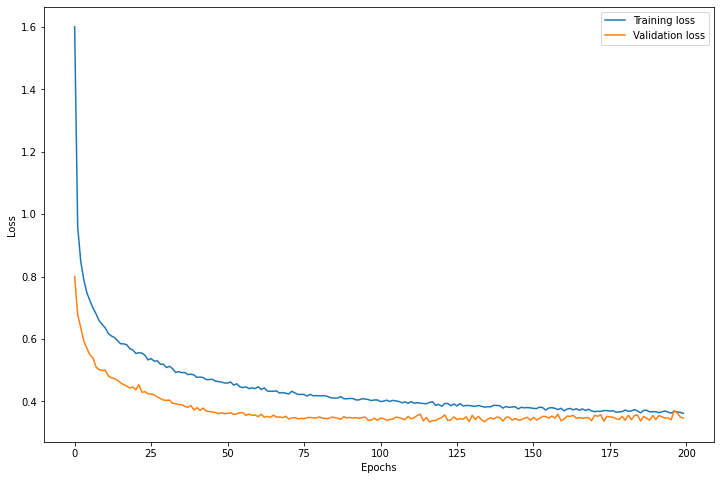

In [50]:
# Plot the training and validation losses
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(train_losses, label='Training loss')
ax.plot(val_losses, label='Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

In [51]:
# Evaluate the model on the test set
test_loss = validate_epoch(cnn, test_dataloader, loss_fn, device) # dont look at the validation, its a test loss
print(f"Test loss: {test_loss}")

100%|██████████| 40/40 [00:01<00:00, 23.74it/s]

Validation loss: 0.3763308525085449
Test loss: 0.3763308525085449


In [52]:
#get the percentage of correct predictions on the test set
correct = 0
total = 0
with torch.no_grad():
    for (data, label) in test_dataloader:
        # Move the input and target data to the selected device
        data, label = data.to(device), label.to(device)
        # Compute the output
        output = cnn(data)
        # Compute the loss
        loss = loss_fn(output, label)
        # Get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True)
        # Add to the total number of correct predictions
        correct += pred.eq(label.view_as(pred)).sum().item()
        # Add to the total number of predictions
        total += data.shape[0]

# Calculate the accuracy
accuracy = correct/total
print(f"Test accuracy: {accuracy}")


Test accuracy: 0.886


## Confusion Matrices

In [53]:
# function to get all predictions
def get_predictions(model, dataloader, device):
    # Set the model to evaluation mode
    model.eval()
    # Initialize the predictions
    predictions = []
    # Loop over the test batches
    with torch.no_grad():
        for (data, label) in tqdm(dataloader):
            # Move the input and target data to the selected device
            data, label = data.to(device), label.to(device)
            # Compute the output
            output = model(data)
            # Get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            # Add to the predictions
            predictions.extend(pred.cpu().numpy().tolist())
    return predictions

#get train dataset predictions
train_predictions = get_predictions(cnn, train_dataloader, device)
# get test dataset predictions
test_predictions = get_predictions(cnn, test_dataloader, device)

#get the labels
train_labels = []
for data, label in tqdm(train_dataloader): #note: to have a reasonable cm, dataloader needs to be without shuffle
    train_labels.extend(label.numpy())

test_labels = []
for data, label in tqdm(test_dataloader):
    test_labels.extend(label.numpy())

print(f"Train labels: {train_labels[:10]}")
print(f"Train predictions: {train_predictions[:10]}")
print(f"Test labels: {test_labels[:10]}")
print(f"Test predictions: {test_predictions[:10]}")

# calculate confusion matrix for train and test set 
import sklearn.metrics as metrics
cm_train = metrics.confusion_matrix(train_labels, train_predictions)
cm_test = metrics.confusion_matrix(test_labels, test_predictions)

100%|██████████| 40/40 [00:01<00:00, 25.98it/s]


Train labels: [5, 4, 0, 5, 0, 3, 5, 9, 0, 3]
Train predictions: [[5], [4], [0], [5], [0], [3], [5], [9], [0], [3]]
Test labels: [9, 2, 1, 1, 6, 1, 4, 6, 5, 7]
Test predictions: [[9], [2], [1], [1], [6], [1], [4], [6], [5], [7]]


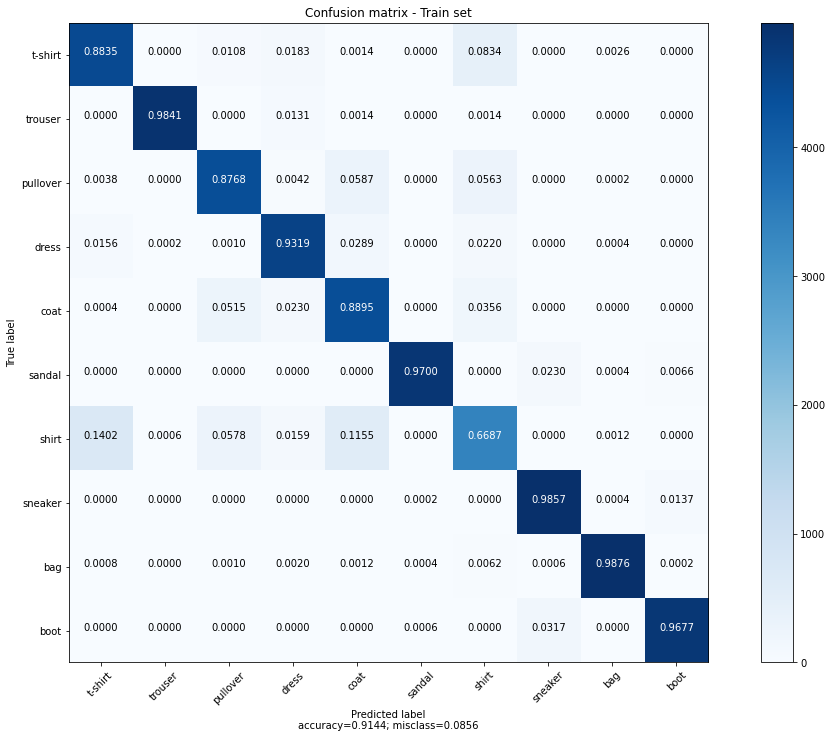

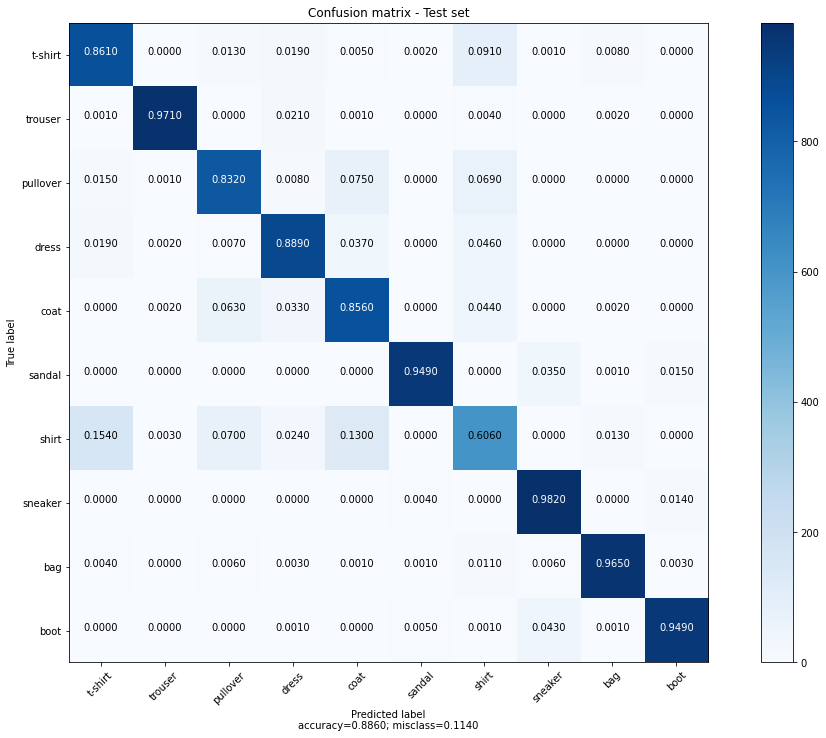

In [54]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import itertools
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

plot_confusion_matrix(cm_train, target_names=label_names, title='Confusion matrix - Train set')
plot_confusion_matrix(cm_test, target_names=label_names, title='Confusion matrix - Test set')

Apparently, shirts can be confused more easily with t-shirts, coats and pullover. 

## Activations